# Requirements

In [41]:
!pip install wikipedia-api

# Import Dataset

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("/Users/panglang/Downloads/videos.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92759 entries, 0 to 92758
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   kind                  92759 non-null  object 
 1   videoId               92759 non-null  int64  
 2   publishedAt           92759 non-null  object 
 3   channelId             92759 non-null  int64  
 4   title                 92759 non-null  object 
 5   description           35237 non-null  object 
 6   tags                  20891 non-null  object 
 7   defaultLanguage       15785 non-null  object 
 8   defaultAudioLanguage  29956 non-null  object 
 9   contentDuration       91492 non-null  object 
 10  viewCount             91490 non-null  float64
 11  likeCount             86630 non-null  float64
 12  favouriteCount        91492 non-null  float64
 13  commentCount          90294 non-null  float64
 14  topicCategories       91228 non-null  object 
dtypes: float64(4), int6

In [43]:
df.head()

,kind,videoId,publishedAt,channelId,title,description,tags,defaultLanguage,defaultAudioLanguage,contentDuration,viewCount,likeCount,favouriteCount,commentCount,topicCategories
0,youtube#video,85806,2024-01-15 00:59:29+00:00,33807,Unlocking the Benefits of Face Masks for Skin ...,NaN,NaN,en-US,en-US,PT9S,72.0,0.0,0.0,0.0,"['https://en.wikipedia.org/wiki/Health', 'http..."
1,youtube#video,30556,2023-10-27 19:32:16+00:00,46650,Get ready for the Magic💚💜🤍💝✨ #hydration #glowi...,NaN,NaN,NaN,NaN,PT45S,257.0,7.0,0.0,0.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...
2,youtube#video,51771,2024-09-28 01:23:22+00:00,14346,#trending #makeup #beautymakeup #yslbeauty #lu...,NaN,NaN,NaN,en-US,PT19S,164.0,4.0,0.0,2.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...
3,youtube#video,45298,2023-07-13 15:19:28+00:00,50139,#shortvedio #balayage,NaN,NaN,NaN,NaN,PT14S,1207.0,20.0,0.0,0.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...
4,youtube#video,43611,2023-04-29 18:47:37+00:00,8143,Full Face of Merit Beauty 🤎 featuring new Flus...,NaN,NaN,NaN,en,PT56S,8647.0,268.0,0.0,7.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...


# Formatting and Cleaning

In [44]:
print(df['kind'].unique())

df.drop('kind', axis=1, inplace=True)

['youtube#video']


In [45]:
df['publishedAt'] = pd.to_datetime(df['publishedAt'])

In [46]:
from datetime import timedelta
import re

# Function to convert ISO 8601 duration string to total seconds
def convert_duration_to_seconds(duration_str):
    if not isinstance(duration_str, str):
        return None

    # Use regular expressions to find hours, minutes, and seconds
    hours = re.search(r'(\d+)H', duration_str)
    minutes = re.search(r'(\d+)M', duration_str)
    seconds = re.search(r'(\d+)S', duration_str)

    h = int(hours.group(1)) if hours else 0
    m = int(minutes.group(1)) if minutes else 0
    s = int(seconds.group(1)) if seconds else 0

    return timedelta(hours=h, minutes=m, seconds=s).total_seconds()

# Apply the conversion function to the 'contentDuration' column
df['contentDuration_seconds'] = df['contentDuration'].apply(convert_duration_to_seconds)

# Feature Generation

## 1. Topic Extraction and Wikipedia Enrichment

In [47]:
# Extract the topic out from the Wikipedia URLs
import ast

def extract_topic_from_wiki(url_list):
    if pd.isna(url_list):
        return []

    # If it's a string that looks like a list, safely parse it
    if isinstance(url_list, str):
        try:
            parsed = ast.literal_eval(url_list)
            if isinstance(parsed, list):
                url_list = parsed
            else:
                url_list = [url_list]
        except Exception:
            url_list = [url_list]

    topics = []
    for url in url_list:
        if not isinstance(url, str):
            continue
        topic = url.split("/")[-1]              # take last part
        topic = topic.replace("_", " ").strip() # underscores → spaces
        topic = topic.strip("']")               # remove trailing ' or ]
        topics.append(topic)

    return topics

df['topicCleaned'] = df['topicCategories'].apply(extract_topic_from_wiki)

In [48]:
#List all the unique topics/categories in this dataset
all_topics = set([t for sublist in df['topicCleaned'] for t in sublist if isinstance(sublist, list)])
print("Total unique topics:", len(all_topics))
print(sorted(all_topics))

Total unique topics: 45
['Action game', 'Action-adventure game', 'Basketball', 'Business', 'Casual game', 'Country music', 'Cricket', 'Electronic music', 'Entertainment', 'Fashion', 'Film', 'Food', 'Health', 'Hip hop music', 'Hobby', 'Humour', 'Jazz', 'Knowledge', 'Lifestyle (sociology)', 'Military', 'Mixed martial arts', 'Music', 'Music of Asia', 'Music of Latin America', 'Performing arts', 'Pet', 'Physical attractiveness', 'Physical fitness', 'Politics', 'Pop music', 'Puzzle video game', 'Religion', 'Rhythm and blues', 'Role-playing video game', 'Society', 'Soul music', 'Sport', 'Sports game', 'Strategy video game', 'Technology', 'Television program', 'Tennis', 'Tourism', 'Vehicle', 'Video game culture']


## 2. Like-View ratio, Comment-view Ratio

In [49]:
df['like_view_ratio'] = np.where(df['viewCount']>0, df['likeCount'] / df['viewCount'], np.nan)
df['comment_view_ratio'] = np.where(df['viewCount']>0, df['commentCount'] / df['viewCount'], np.nan)

## 3. Video duration segmentation

In [50]:
bins = [0, 30, 120, 300, 900, 3600, np.inf]
labels = ['<30s', '30-120s', '2-5m', '5-15m', '15-60m', '>60m']
try:
  df['length_bucket'] = pd.cut(df['contentDuration_seconds'].fillna(-1), bins=[-1,30,120,300,900,3600,10**9], labels=labels)
except Exception:
  df['length_bucket'] = 'unknown'

## 4. Tags Cleaning

In [51]:
def extract_hashtags(text):
  if pd.isna(text):
    return []
  return re.findall(r"#(\w+)", str(text))

hashtags_from_title = df['title'].apply(extract_hashtags) if 'title' in df.columns else [[] for _ in range(len(df))]
hashtags_from_desc = df['description'].apply(extract_hashtags) if 'description' in df.columns else [[] for _ in range(len(df))]

def ensure_list(x):
    if isinstance(x, list):
        return x
    if pd.isna(x):
        return []
    return [x]

merged_tags = []
for base, ht1, ht2 in zip(df['tags'], hashtags_from_title, hashtags_from_desc):
  base = ensure_list(base)
  ht1 = ensure_list(ht1)
  ht2 = ensure_list(ht2)
  merged = list(set(base) | set(ht1) | set(ht2))
  merged_tags.append(merged)


df['tags'] = merged_tags

In [52]:
# Attempt to enrich dataset with more information from wikipedia
import wikipediaapi
import requests

import urllib.parse
from datetime import datetime

def get_wiki_pageviews(page_title, start="20230101", end=None):
    if end is None:
        # default to today's date in YYYYMMDD
        end = datetime.today().strftime("%Y%m%d")

    # Encode title properly for Wikimedia API
    encoded_title = urllib.parse.quote(page_title, safe="")

    url = f"https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/{encoded_title}/daily/{start}/{end}"
    r = requests.get(url)

    if r.status_code == 200:
        data = r.json().get("items", [])
        if data:
            return sum(item["views"] for item in data)
    return 0  # return 0 instead of None if no data

wiki_wiki = wikipediaapi.Wikipedia(user_agent="LoReal (ryanchinjh@gmail.com)", language='en')



def enrich_wiki_topic(topic_url):
    try:
        topic = topic_url.split("/")[-1]
        page_title = topic  # keep underscores
        page = wiki_wiki.page(topic.replace("_", " "))
        summary = page.summary[0:500] if page.exists() else None
        pageviews = get_wiki_pageviews(page_title)
        return {
            "topic": topic.replace("_", " "),
            #"summary": summary,
            "categories": list(page.categories.keys()) if page.exists() else [],
            "pageviews": pageviews
        }
    except Exception:
        return {"topic": None, "summary": None, "categories": [], "pageviews": 0}

print(enrich_wiki_topic("https://en.wikipedia.org/wiki/Lifestyle_(sociology)"))

{'topic': 'Lifestyle (sociology)', 'categories': ['Category:1920s neologisms', 'Category:Articles containing German-language text', 'Category:Articles with short description', 'Category:Lifestyle', 'Category:Personal life', 'Category:Philosophy of life', 'Category:Short description matches Wikidata', 'Category:Sociological terminology', 'Category:Subcultures', 'Category:Webarchive template wayback links', 'Category:Wikipedia indefinitely semi-protected pages'], 'pageviews': 0}


**Note: Page views still don't work. Will look into it more later**

# Creating separate dataframe for channel stats

In [53]:
channel_df = df.groupby('channelId')['viewCount'].sum()

In [54]:
channel_agg = df.groupby('channelId').agg(
    total_view=('viewCount', 'sum'),
    average_view=('viewCount', 'mean'),
    video_count = ('channelId', 'count')
).reset_index()

q = channel_agg['average_view'].quantile([0.33,0.66]).to_list()
small_th, medium_th = q[0], q[1]


def channel_size_label(avg):
  if pd.isna(avg):
    return 'unknown'
  if avg <= small_th:
    return 'small'
  if avg <= medium_th:
    return 'medium'
  return 'large'

channel_agg['channel_size'] = channel_agg['average_view'].apply(channel_size_label)

channel_agg.head(10)

,channelId,total_view,average_view,video_count,channel_size
0,0,546.0,546.0,1,medium
1,1,850374.0,850374.0,1,large
2,2,253.0,253.0,1,small
3,3,459.0,459.0,1,medium
4,4,4.0,4.0,1,small
5,5,10.0,10.0,1,small
6,6,1535.0,767.5,2,medium
7,7,113.0,113.0,1,small
8,8,609.0,609.0,1,medium
9,9,549.0,274.5,2,small


# EDA

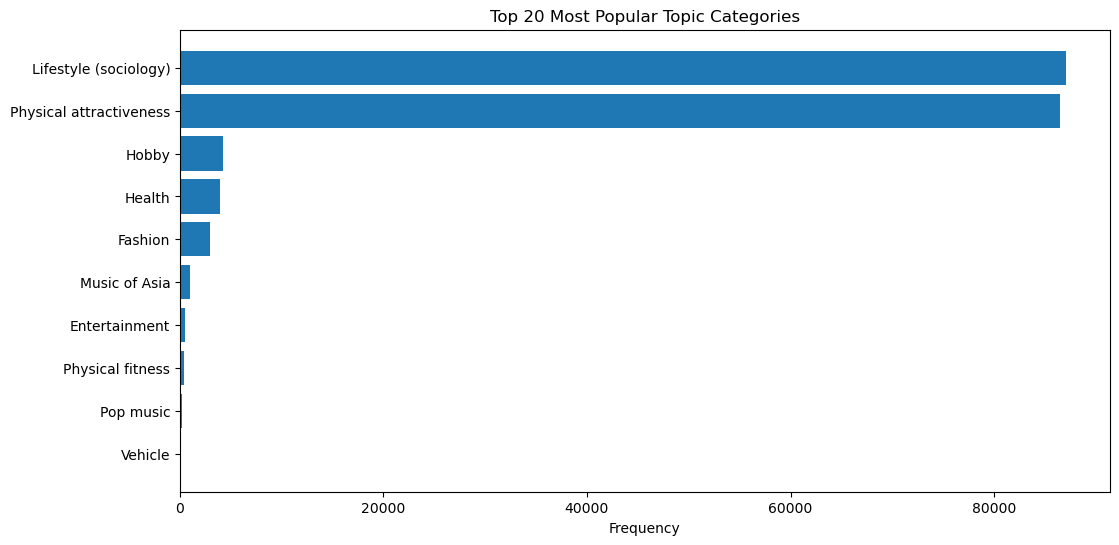

In [55]:
from collections import Counter
all_topics = [t for sublist in df['topicCleaned'] for t in sublist if isinstance(sublist, list)]
topic_counts = Counter(all_topics)

# Get top 10 categories
top_topics = topic_counts.most_common(10)

# Separate labels and values
labels, values = zip(*top_topics)

# Plot
plt.figure(figsize=(12,6))
plt.barh(labels, values)
plt.xlabel("Frequency")
plt.title("Top 20 Most Popular Topic Categories")
plt.gca().invert_yaxis()  # largest on top
plt.show()

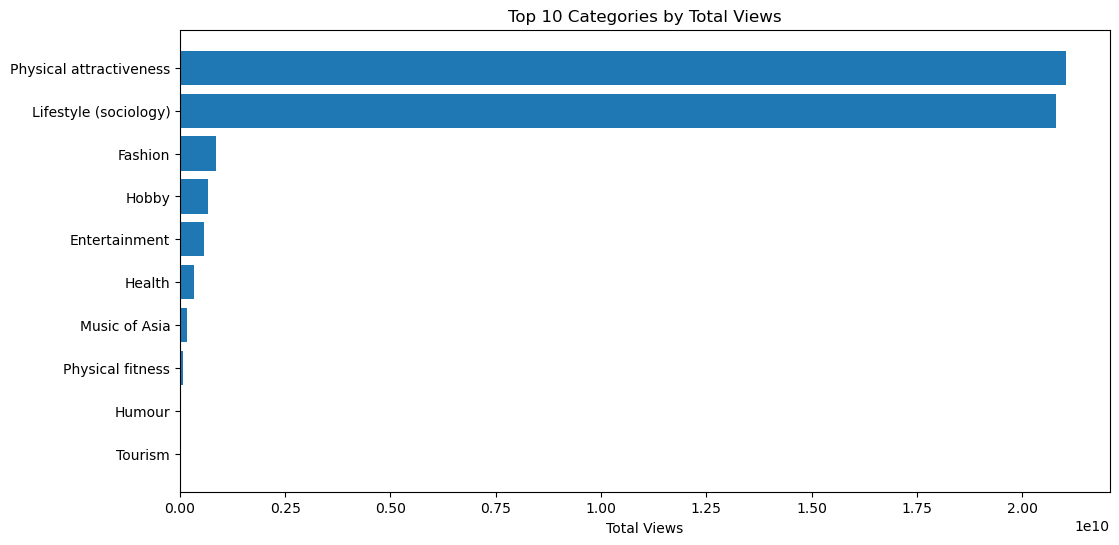

In [56]:
from collections import defaultdict
category_views = defaultdict(int)

# Sum views per category
for cats, views in zip(df['topicCleaned'], df['viewCount']):
    if not isinstance(cats, list):
        continue
    try:
        v = int(views)
    except Exception:
        v = 0
    for c in cats:
        category_views[c] += v

# Sort and take top 10
top_by_views = sorted(category_views.items(), key=lambda x: x[1], reverse=True)[:10]
labels, values = zip(*top_by_views)

# Plot
plt.figure(figsize=(12,6))
plt.barh(labels, values)
plt.xlabel("Total Views")
plt.title("Top 10 Categories by Total Views")
plt.gca().invert_yaxis()
plt.show()

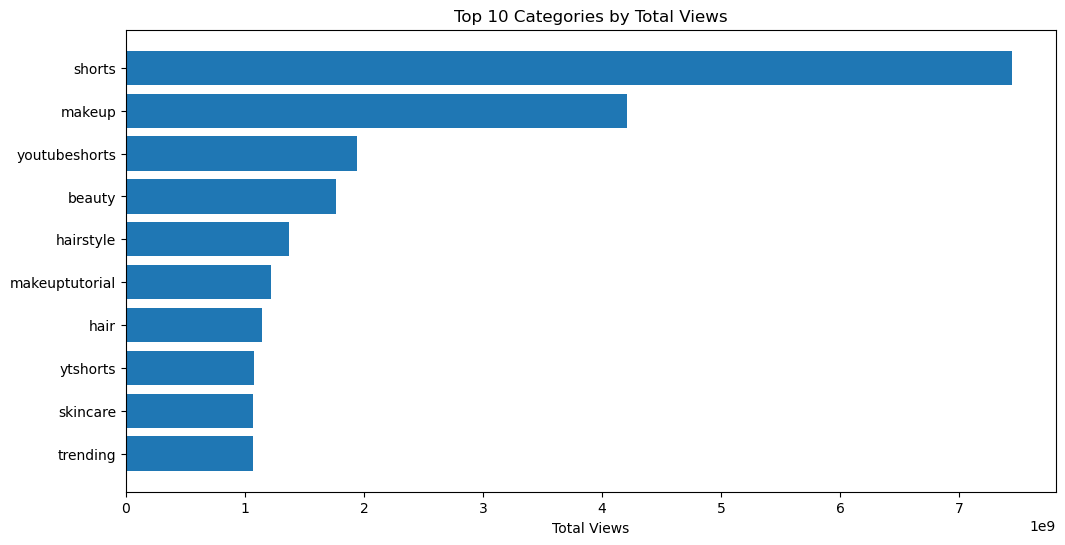

In [57]:
tags_views = defaultdict(int)

# Sum views per category
for tags, views in zip(df['tags'], df['viewCount']):
    if not isinstance(cats, list):
        continue
    try:
        v = int(views)
    except Exception:
        v = 0
    for t in tags:
        tags_views[t] += v

# Sort and take top 10
top_by_views = sorted(tags_views.items(), key=lambda x: x[1], reverse=True)[:10]
labels, values = zip(*top_by_views)

# Plot
plt.figure(figsize=(12,6))
plt.barh(labels, values)
plt.xlabel("Total Views")
plt.title("Top 10 Categories by Total Views")
plt.gca().invert_yaxis()
plt.show()

In [58]:
df['upload_month'] = df['publishedAt'].dt.to_period('M').apply(lambda r: r.start_time.date())

/var/folders/ys/ykx0_rtd2nl_vpp4rcj5tpp00000gn/T/ipykernel_3233/1688453371.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['upload_month'] = df['publishedAt'].dt.to_period('M').apply(lambda r: r.start_time.date())


/var/folders/ys/ykx0_rtd2nl_vpp4rcj5tpp00000gn/T/ipykernel_3233/171908774.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_exploded['month'] = df_exploded['publishedAt'].dt.to_period('M')


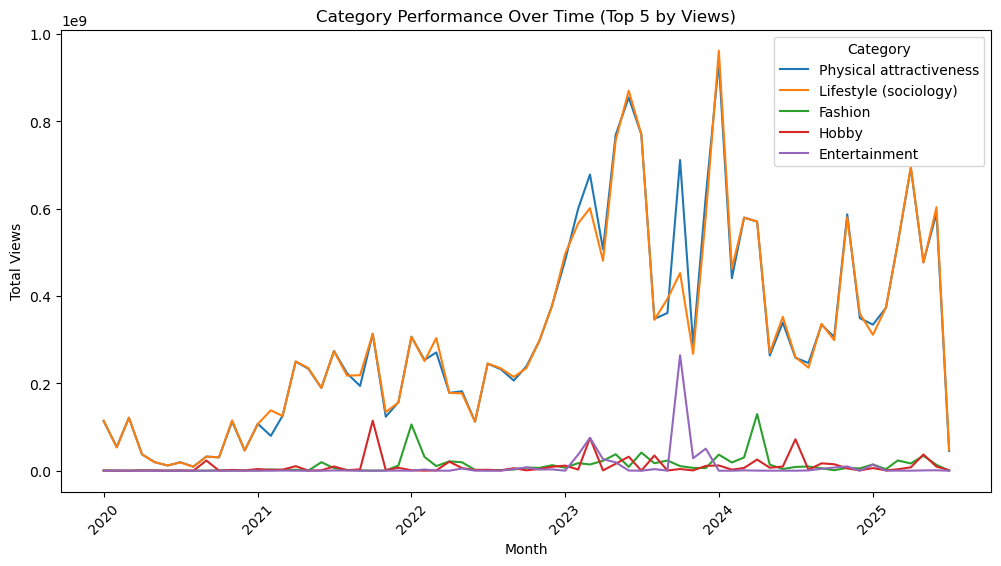

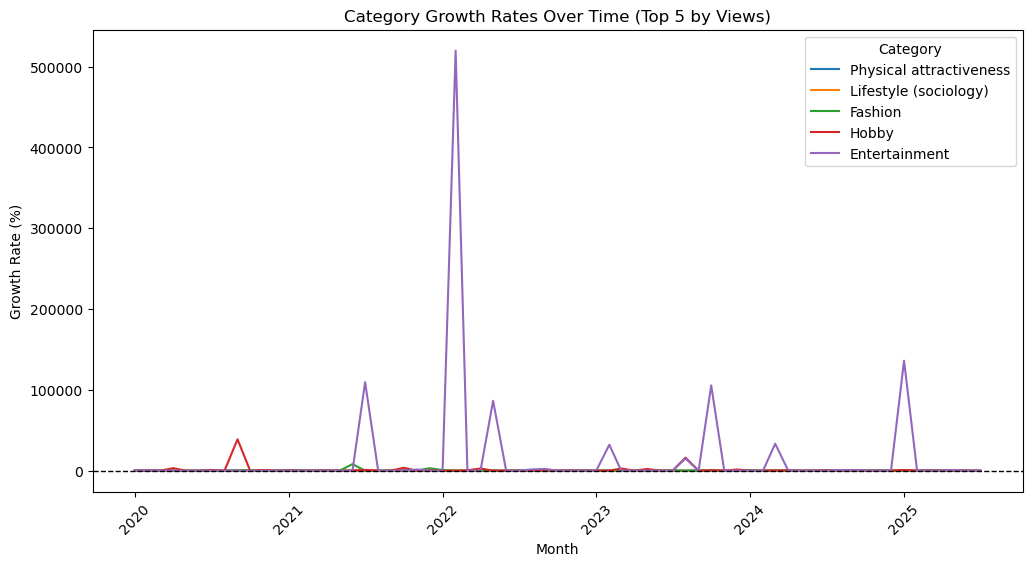

In [59]:
# Explode categories so each video-category pair becomes its own row
df_exploded = df.explode('topicCleaned')
df_exploded = df_exploded.dropna(subset=['topicCleaned'])

# Group by month and category
df_exploded['month'] = df_exploded['publishedAt'].dt.to_period('M')
cat_time = (
    df_exploded.groupby(['upload_month','topicCleaned'])['viewCount']
    .sum()
    .reset_index()
)

# Pivot for plotting
cat_pivot = cat_time.pivot(index='upload_month', columns='topicCleaned', values='viewCount').fillna(0)

# Compute growth rate = percentage change month-to-month
cat_growth = cat_pivot.pct_change().replace([np.inf, -np.inf], np.nan).fillna(0)

# Plot top 5 categories by total views
top5_cats = cat_pivot.sum().sort_values(ascending=False).head(5).index
cat_pivot[top5_cats].plot(figsize=(12,6))
plt.title("Category Performance Over Time (Top 5 by Views)")
plt.ylabel("Total Views")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.legend(title="Category")
plt.show()

# ---- Plot Growth Rates ----
plt.figure(figsize=(12,6))
(cat_growth[top5_cats] * 100).plot(ax=plt.gca())
plt.title("Category Growth Rates Over Time (Top 5 by Views)")
plt.ylabel("Growth Rate (%)")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.legend(title="Category")
plt.show()

/var/folders/ys/ykx0_rtd2nl_vpp4rcj5tpp00000gn/T/ipykernel_3233/3686110200.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_exploded['month'] = df_exploded['publishedAt'].dt.to_period('M')


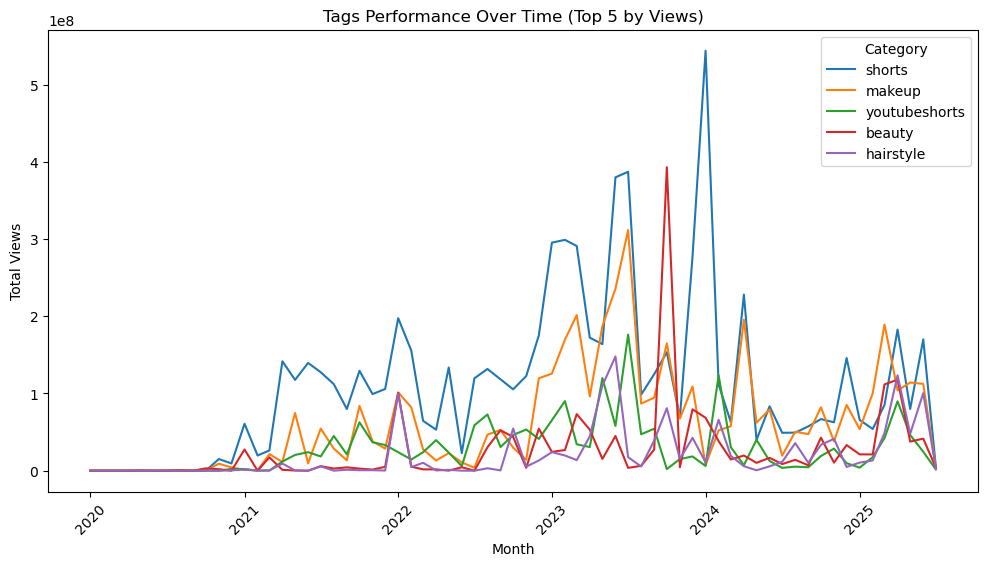

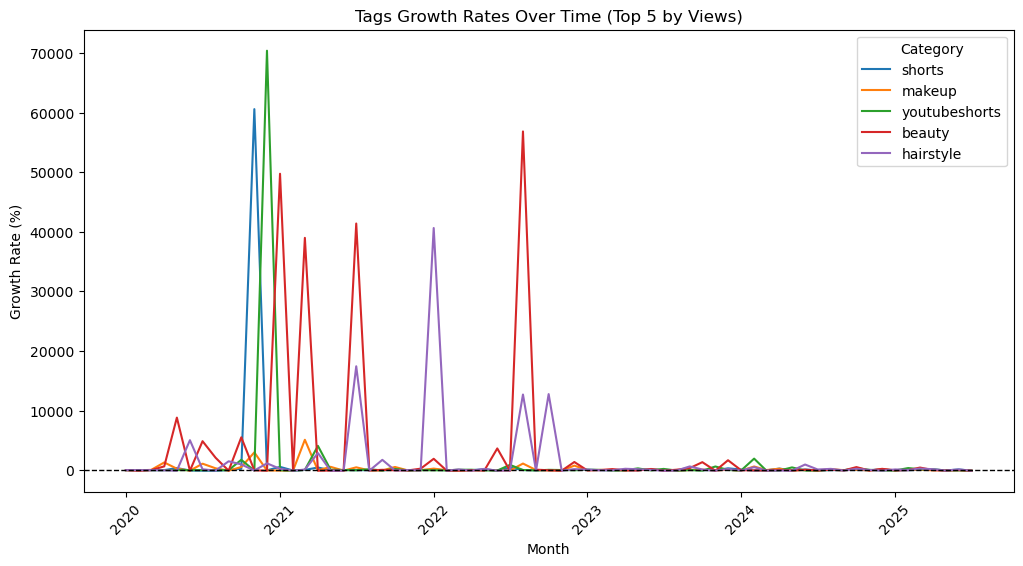

In [60]:
# Explode categories so each video-category pair becomes its own row
df_exploded = df.explode('tags')
df_exploded = df_exploded.dropna(subset=['tags'])

# Group by month and category
df_exploded['month'] = df_exploded['publishedAt'].dt.to_period('M')
tag_time = (
    df_exploded.groupby(['upload_month','tags'])['viewCount']
    .sum()
    .reset_index()
)

# Pivot for plotting
tag_pivot = tag_time.pivot(index='upload_month', columns='tags', values='viewCount').fillna(0)

tag_growth = tag_pivot.pct_change().replace([np.inf, -np.inf], np.nan).fillna(0)

# Plot top 5 tags by total views
top5_tags = tag_pivot.sum().sort_values(ascending=False).head(5).index
tag_pivot[top5_tags].plot(figsize=(12,6))
plt.title("Tags Performance Over Time (Top 5 by Views)")
plt.ylabel("Total Views")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.legend(title="Category")
plt.show()

# ---- Plot Growth Rates ----
plt.figure(figsize=(12,6))
(tag_growth[top5_tags] * 100).plot(ax=plt.gca())
plt.title("Tags Growth Rates Over Time (Top 5 by Views)")
plt.ylabel("Growth Rate (%)")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.legend(title="Category")
plt.show()

In [61]:
# Expand categories
df_exploded = df.explode('topicCleaned').dropna(subset=['topicCleaned'])
df_exploded['month'] = df_exploded['publishedAt'].dt.to_period('M')

# Aggregate views
cat_time = (
    df_exploded.groupby(['month','topicCleaned'])['viewCount']
    .sum()
    .reset_index()
)

# Pivot into time series
cat_pivot = cat_time.pivot(index='month', columns='topicCleaned', values='viewCount').fillna(0)

entry_decay_points = {}

for cat in cat_pivot.columns:
    series = cat_pivot[cat].astype(float)
    growth = series.pct_change().replace([np.inf, -np.inf], np.nan).fillna(0)

    entry, decay = None, None

    # Entry: first month with big positive growth (>50% increase over previous month)
    for date, g in growth.items():
        if g > 0.5 and entry is None:
            entry = date
            break

    # Decay: first month after entry with strong decline (< -30%)
    if entry:
        after_entry = growth[series.index >= entry]
        for date, g in after_entry.items():
            if g < -0.3:
                decay = date
                break

    entry_decay_points[cat] = {"entry": entry, "decay": decay}

# Convert to DataFrame for easier inspection
entry_decay_df = (
    pd.DataFrame(entry_decay_points).T
    .reset_index()
    .rename(columns={"index": "category"})
)

print("Entry & Decay Points Detected:")
print(entry_decay_df.head(20))

Entry & Decay Points Detected:
                 category    entry    decay
0             Action game     None     None
1   Action-adventure game     None     None
2              Basketball     None     None
3                Business     None     None
4             Casual game     None     None
5           Country music     None     None
6                 Cricket     None     None
7        Electronic music  2025-06  2025-07
8           Entertainment  2020-02  2020-03
9                 Fashion  2020-04  2020-06
10                   Film  2020-02  2020-03
11                   Food  2025-06  2025-07
12                 Health  2020-02  2020-03
13          Hip hop music  2021-07  2021-08
14                  Hobby  2020-02  2020-03
15                 Humour  2023-01  2023-02
16                   Jazz     None     None
17              Knowledge  2020-02  2020-03
18  Lifestyle (sociology)  2020-03  2020-04
19               Military     None     None


/var/folders/ys/ykx0_rtd2nl_vpp4rcj5tpp00000gn/T/ipykernel_3233/3292859334.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_exploded['month'] = df_exploded['publishedAt'].dt.to_period('M')


## Identify Emerging Trend

In [62]:
# Group by month and calculate mean engagement ratios
engagement_time = (
    df.groupby(df['publishedAt'].dt.to_period('M'))[['like_view_ratio', 'comment_view_ratio']]
    .mean()
    .reset_index()
    .rename(columns={'publishedAt': 'month'})
)

# Calculate engagement rate and its growth
engagement_time['engagement_rate'] = engagement_time['like_view_ratio'] + engagement_time['comment_view_ratio']
engagement_time['engagement_growth'] = engagement_time['engagement_rate'].pct_change().replace([np.inf, -np.inf], np.nan).fillna(0)

print(engagement_time.head())

     month  like_view_ratio  comment_view_ratio  engagement_rate  \
0  2020-01         0.048429            0.007195         0.055624   
1  2020-02         0.040309            0.010670         0.050979   
2  2020-03         0.049933            0.013712         0.063645   
3  2020-04         0.052670            0.011942         0.064613   
4  2020-05         0.063402            0.024285         0.087686   

   engagement_growth  
0           0.000000  
1          -0.083501  
2           0.248441  
3           0.015210  
4           0.357106  


/var/folders/ys/ykx0_rtd2nl_vpp4rcj5tpp00000gn/T/ipykernel_3233/3530528464.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df.groupby(df['publishedAt'].dt.to_period('M'))[['like_view_ratio', 'comment_view_ratio']]


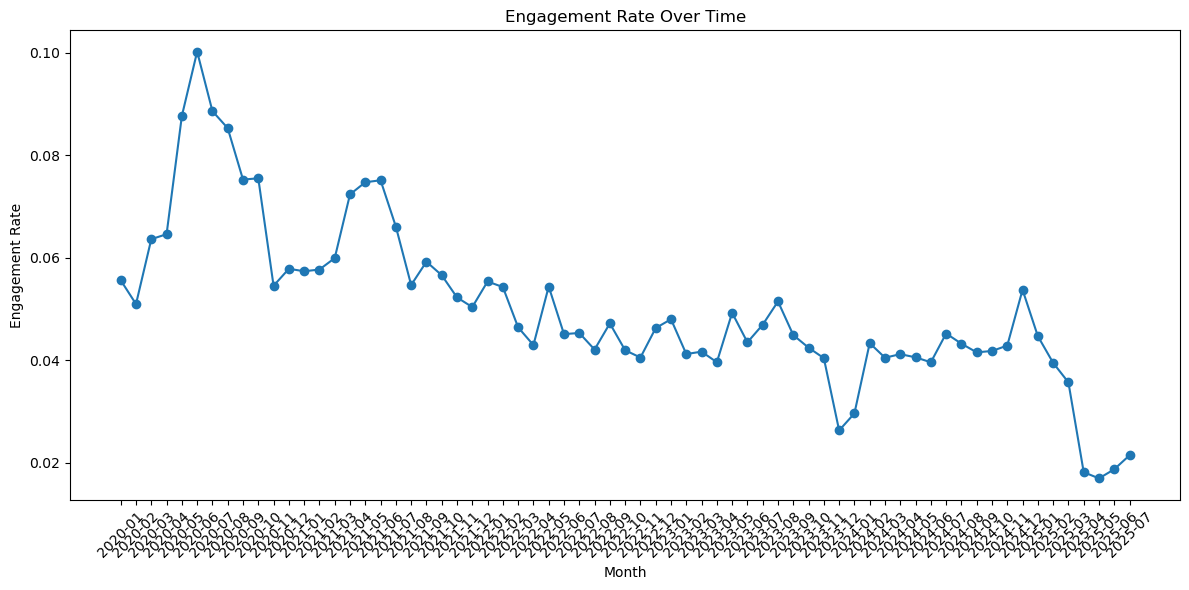

In [63]:
#plot engagement rate over time
plt.figure(figsize=(12, 6))
plt.plot(engagement_time['month'].astype(str), engagement_time['engagement_rate'], marker='o')
plt.title('Engagement Rate Over Time')
plt.xlabel('Month')
plt.ylabel('Engagement Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### To identify emerging topics and tags trend using engagement rate for quality of interaction

In [64]:
# Define recent and historical periods (last 6 months vs. earlier)
recent_months = df['upload_month'].sort_values().unique()[-6:]
historical_months = df['upload_month'].sort_values().unique()[:-6]

# Calculate engagement rates for each topic in recent and historical periods
recent_engagement = (
    df[df['upload_month'].isin(recent_months)]
    .explode('topicCleaned')
    .groupby('topicCleaned')[['like_view_ratio', 'comment_view_ratio']]
    .mean()
)
recent_engagement['engagement_rate'] = recent_engagement['like_view_ratio'] + recent_engagement['comment_view_ratio']

historical_engagement = (
    df[df['upload_month'].isin(historical_months)]
    .explode('topicCleaned')
    .groupby('topicCleaned')[['like_view_ratio', 'comment_view_ratio']]
    .mean()
)
historical_engagement['engagement_rate'] = historical_engagement['like_view_ratio'] + historical_engagement['comment_view_ratio']

# Merge and compare
topic_trends = recent_engagement[['engagement_rate']].rename(columns={'engagement_rate': 'recent_engagement_rate'}).join(
    historical_engagement[['engagement_rate']].rename(columns={'engagement_rate': 'historical_engagement_rate'}),
    how='outer'
)
topic_trends['change'] = topic_trends['recent_engagement_rate'] - topic_trends['historical_engagement_rate']

# Emerging: recent engagement rate much higher than historical
emerging_topics = topic_trends[topic_trends['change'] > 0.1].sort_values('change', ascending=False)
print("Emerging Topics (recent engagement rate > historical):")
print(emerging_topics.head(20))

# Established: consistently high engagement
established_topics = topic_trends[
    (topic_trends['recent_engagement_rate'] > topic_trends['recent_engagement_rate'].mean()) &
    (topic_trends['historical_engagement_rate'] > topic_trends['historical_engagement_rate'].mean())
].sort_values('recent_engagement_rate', ascending=False)
print("\nEstablished Topics (consistently high engagement):")
print(established_topics.head(20))


Emerging Topics (recent engagement rate > historical):
              recent_engagement_rate  historical_engagement_rate    change
topicCleaned                                                              
Food                        0.248318                    0.012005  0.236313

Established Topics (consistently high engagement):
                         recent_engagement_rate  historical_engagement_rate  \
topicCleaned                                                                  
Action-adventure game                  0.080858                    0.042588   
Puzzle video game                      0.075472                    0.052174   
Role-playing video game                0.073101                    0.049466   
Video game culture                     0.062591                    0.041530   
Electronic music                       0.060317                    0.048398   
Strategy video game                    0.059050                    0.044057   
Action game                         

In [65]:
# Identify trending tags based on engagement rates over time
# Calculate engagement rates for each tag in recent and historical periods
recent_tag_engagement = (
    df[df['upload_month'].isin(recent_months)]
    .explode('tags')
    .groupby('tags')[['like_view_ratio', 'comment_view_ratio']]
    .mean()
)
recent_tag_engagement['engagement_rate'] = recent_tag_engagement['like_view_ratio'] + recent_tag_engagement['comment_view_ratio']

historical_tag_engagement = (
    df[df['upload_month'].isin(historical_months)]
    .explode('tags')
    .groupby('tags')[['like_view_ratio', 'comment_view_ratio']]
    .mean()
)
historical_tag_engagement['engagement_rate'] = historical_tag_engagement['like_view_ratio'] + historical_tag_engagement['comment_view_ratio']

# Merge and compare
tag_trends = recent_tag_engagement[['engagement_rate']].rename(columns={'engagement_rate': 'recent_engagement_rate'}).join(
    historical_tag_engagement[['engagement_rate']].rename(columns={'engagement_rate': 'historical_engagement_rate'}),
    how='outer'
)
tag_trends['change'] = tag_trends['recent_engagement_rate'] - tag_trends['historical_engagement_rate']

# Emerging tags: recent engagement rate much higher than historical
emerging_tags = tag_trends[tag_trends['change'] > 0.05].sort_values('change', ascending=False)
print("Emerging Tags (recent engagement rate > historical):")
print(emerging_tags.head(20))

# Established tags: consistently high engagement
established_tags = tag_trends[
    (tag_trends['recent_engagement_rate'] > tag_trends['recent_engagement_rate'].mean()) &
    (tag_trends['historical_engagement_rate'] > tag_trends['historical_engagement_rate'].mean())
].sort_values('recent_engagement_rate', ascending=False)
print("\nEstablished Tags (consistently high engagement):")
print(established_tags.head(20))

Emerging Tags (recent engagement rate > historical):
                       recent_engagement_rate  historical_engagement_rate  \
tags                                                                        
ProductReviews                       2.000000                    0.000000   
GadgetLover                          2.000000                    0.018612   
OnlineShopping                       2.000000                    0.023443   
AmazonDeals                          2.000000                    0.030686   
Unboxing                             2.000000                    0.148210   
beautifull                           1.000000                    0.116950   
ViralProducts                        0.685812                    0.000000   
VitaminCGlow                         0.484436                    0.025000   
SkincareEssentials                   0.503352                    0.052504   
SalonAd                              0.395382                    0.033333   
some                   

### To identify emerging topics and tags trend using higher average growth rate for quantity of attention

In [66]:
# Identify emerging category trends: categories with strong recent growth
# Calculate average growth rate for each category over the last 6 months
recent_months = cat_growth.index[-6:]
avg_growth = cat_growth.loc[recent_months].mean()
# Filter categories with high average growth (e.g., > 0.5 or 50%)
emerging_cats = avg_growth[avg_growth > 0.5].sort_values(
    ascending=False
)   
print("Emerging category trends (avg growth > 50% over last 6 months):")
print(emerging_cats.head(20))

Emerging category trends (avg growth > 50% over last 6 months):
topicCleaned
Knowledge             1270.715600
Film                   936.603344
Humour                 311.325323
Television program      55.511163
Pop music               12.727724
Performing arts          7.477397
Music of Asia            4.381170
Physical fitness         2.806720
Entertainment            1.415650
Health                   1.371738
Music                    1.007836
Hobby                    0.919068
Society                  0.716346
Fashion                  0.680987
dtype: float64


In [67]:
# Identiify emerging tag trends: tags with strong recent growth
# Calculate average growth rate for each tag over the last 6 months
recent_months = tag_growth.index[-6:]
avg_tag_growth = tag_growth.loc[recent_months].mean()
# Filter tags with high average growth (e.g., > 0.5 or 50
emerging_tags = avg_tag_growth[avg_tag_growth > 0.5].sort_values(
    ascending=False
)       
print("Emerging tag trends (avg growth > 50% over last 6 months):")
print(emerging_tags.head(20))

Emerging tag trends (avg growth > 50% over last 6 months):
tags
coffee             42622.190667
nature             32950.598291
scarf              24965.466667
viralsong          23866.091248
curlyhairstyles    20455.226467
VitaminCSerum      19591.948276
hairlook           18213.742300
water              15864.688615
challenge          15143.814651
Haircut            12319.870605
wigtutorial        11134.337773
BeautyTrends        9723.650597
woman               6903.848934
glowuproutine       6775.359795
facecaretips        6653.972222
workout             6276.522296
trendingvideos      6108.576393
smokeyeyes          5059.939443
skills              4616.269062
hairsystem          4555.759484
dtype: float64


### Ranking topics by total views, engagement rate growth, and upload volume

In [68]:
# Define recent period (last 2 months for sharper trend, or adjust as needed)
recent_weeks = df['publishedAt'].dt.to_period('W').sort_values().unique()[-8:]
recent_months = df['upload_month'].sort_values().unique()[-2:]  # last 2 months

# 1. Total views by topic in recent period
recent_df = df[df['upload_month'].isin(recent_months)].explode('topicCleaned')
topic_views = recent_df.groupby('topicCleaned')['viewCount'].sum().sort_values(ascending=False)

# 2. Engagement rate growth over time (last 8 weeks)
weekly_engagement = (
    df.explode('topicCleaned')
    .groupby([df['publishedAt'].dt.to_period('W'), 'topicCleaned'])[['like_view_ratio', 'comment_view_ratio']]
    .mean()
    .reset_index()
)
weekly_engagement['engagement_rate'] = weekly_engagement['like_view_ratio'] + weekly_engagement['comment_view_ratio']

# Pivot for growth calculation
engagement_pivot = weekly_engagement.pivot(index='publishedAt', columns='topicCleaned', values='engagement_rate').fillna(0)
engagement_growth = engagement_pivot.pct_change().replace([np.inf, -np.inf], np.nan).fillna(0)
recent_growth = engagement_growth.iloc[-4:].mean()  # last 4 weeks

# 3. Volume of uploads by topic in recent period
topic_uploads = recent_df.groupby('topicCleaned').size().sort_values(ascending=False)

# Combine into DataFrame
topic_rank = pd.DataFrame({
    'total_views_recent': topic_views,
    'engagement_growth_recent': recent_growth,
    'upload_volume_recent': topic_uploads
}).fillna(0)

# Rank topics by each metric
topic_rank['views_rank'] = topic_rank['total_views_recent'].rank(ascending=False)
topic_rank['growth_rank'] = topic_rank['engagement_growth_recent'].rank(ascending=False)
topic_rank['uploads_rank'] = topic_rank['upload_volume_recent'].rank(ascending=False)

# Calculate overall rank (average of ranks)
topic_rank['overall_rank'] = topic_rank[['views_rank', 'growth_rank', 'uploads_rank']].mean(axis=1)

# Flag topics with sharp increase in ranking (compare current vs. previous month)
prev_months = df['upload_month'].sort_values().unique()[-4:-2]
prev_df = df[df['upload_month'].isin(prev_months)].explode('topicCleaned')
prev_topic_views = prev_df.groupby('topicCleaned')['viewCount'].sum()
prev_topic_uploads = prev_df.groupby('topicCleaned').size()

topic_rank['prev_views'] = topic_rank.index.map(prev_topic_views).fillna(0)
topic_rank['prev_uploads'] = topic_rank.index.map(prev_topic_uploads).fillna(0)
topic_rank['views_increase'] = topic_rank['total_views_recent'] - topic_rank['prev_views']
topic_rank['uploads_increase'] = topic_rank['upload_volume_recent'] - topic_rank['prev_uploads']

# Flag sharp increases (e.g., >50% increase)
topic_rank['sharp_increase_flag'] = (
    (topic_rank['views_increase'] > topic_rank['prev_views'] * 0.5) |
    (topic_rank['uploads_increase'] > topic_rank['prev_uploads'] * 0.5)
)

# Show top topics and flagged sharp increases
print(topic_rank.sort_values('overall_rank').head(20))
print("\nTopics with sharp increase in ranking:")
print(topic_rank[topic_rank['sharp_increase_flag']].sort_values('overall_rank').head(20))


/var/folders/ys/ykx0_rtd2nl_vpp4rcj5tpp00000gn/T/ipykernel_3233/3319407654.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  recent_weeks = df['publishedAt'].dt.to_period('W').sort_values().unique()[-8:]
/var/folders/ys/ykx0_rtd2nl_vpp4rcj5tpp00000gn/T/ipykernel_3233/3319407654.py:12: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  .groupby([df['publishedAt'].dt.to_period('W'), 'topicCleaned'])[['like_view_ratio', 'comment_view_ratio']]


                         total_views_recent  engagement_growth_recent  \
topicCleaned                                                            
Lifestyle (sociology)           650694461.0                  0.023922   
Physical attractiveness         635550037.0                  0.029732   
Pop music                         9615002.0                  1.159317   
Music of Asia                     2998454.0                  0.156515   
Health                            8912940.0                 -0.045155   
Hobby                            10626202.0                 -0.088264   
Action-adventure game                4654.0                  0.530793   
Physical fitness                  1937149.0                 -0.109379   
Fashion                          13468519.0                 -0.271874   
Video game culture                   7065.0                 -0.113110   
Action game                          6180.0                 -0.122609   
Television program                  20833.0        

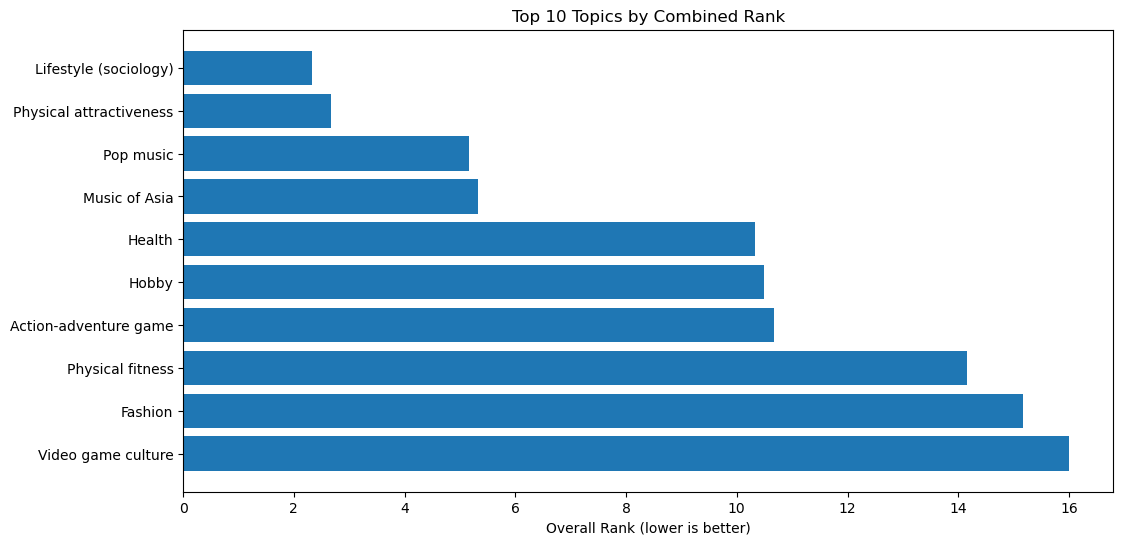

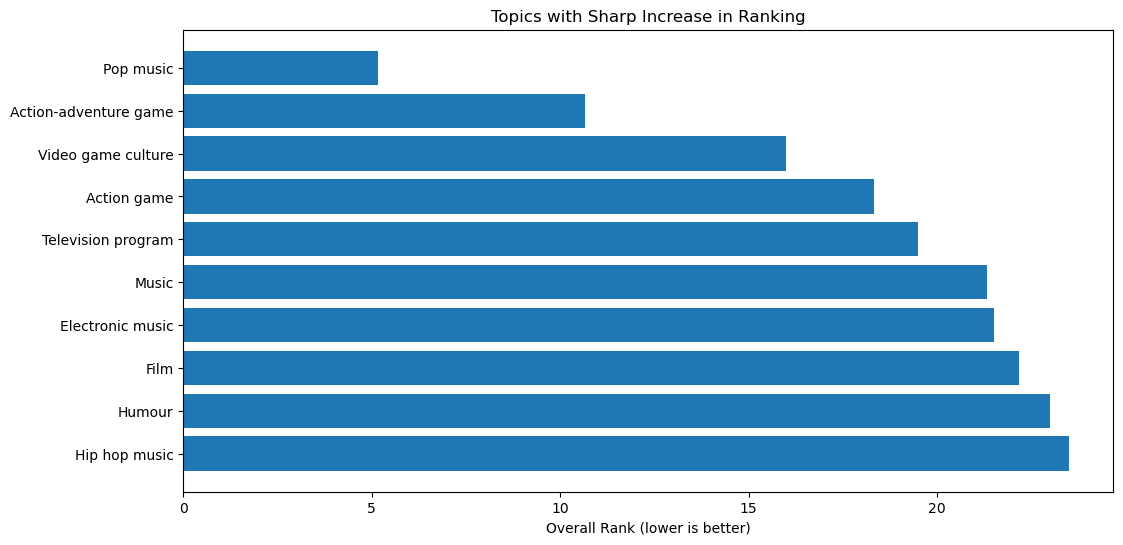

In [69]:
# Plot top 10 topics by overall rank
top_topics = topic_rank.sort_values('overall_rank').head(10)
plt.figure(figsize=(12,6))
plt.barh(top_topics.index, top_topics['overall_rank'])
plt.xlabel('Overall Rank (lower is better)')
plt.title('Top 10 Topics by Combined Rank')
plt.gca().invert_yaxis()
plt.show()

# Plot topics with sharp increase in ranking
sharp_increase = topic_rank[topic_rank['sharp_increase_flag']].sort_values('overall_rank').head(10)
plt.figure(figsize=(12,6))
plt.barh(sharp_increase.index, sharp_increase['overall_rank'])
plt.xlabel('Overall Rank (lower is better)')
plt.title('Topics with Sharp Increase in Ranking')
plt.gca().invert_yaxis()
plt.show()

### Identify new hashtags appearing frequently in the last 2–4 weeks and measure velocity

In [70]:
# Explode tags for analysis
df_tags = df.explode('tags')
df_tags['week'] = df_tags['publishedAt'].dt.to_period('W')

# Define recent and historical periods
all_weeks = df_tags['week'].sort_values().unique()
recent_weeks = all_weeks[-4:]  # last 4 weeks
historical_weeks = all_weeks[:-4]  # all weeks before last 4

# Frequency of tags in recent and historical periods
recent_freq = (
    df_tags[df_tags['week'].isin(recent_weeks)]
    .groupby('tags').size()
    .rename('recent_count')
)
historical_freq = (
    df_tags[df_tags['week'].isin(historical_weeks)]
    .groupby('tags').size()
    .rename('historical_count')
)

# Combine and calculate velocity
tag_velocity = pd.DataFrame({'recent_count': recent_freq, 'historical_count': historical_freq}).fillna(0)
tag_velocity['velocity'] = (tag_velocity['recent_count'] - tag_velocity['historical_count']) / (tag_velocity['historical_count'] + 1e-6)

# Identify new hashtags (not present in historical)
tag_velocity['is_new'] = tag_velocity['historical_count'] == 0

# Sort by velocity
tag_velocity_sorted = tag_velocity.sort_values('velocity', ascending=False)

print("Top new hashtags (appearing in last 4 weeks):")
print(tag_velocity_sorted[tag_velocity_sorted['is_new']].head(20))

print("\nTop hashtags by velocity (frequency growth rate):")
print(tag_velocity_sorted.head(20))

/var/folders/ys/ykx0_rtd2nl_vpp4rcj5tpp00000gn/T/ipykernel_3233/1907014852.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_tags['week'] = df_tags['publishedAt'].dt.to_period('W')


Top new hashtags (appearing in last 4 weeks):
                         recent_count  historical_count   velocity  is_new
tags                                                                      
MakeupTrend                       7.0               0.0  7000000.0    True
MakeupEdit                        4.0               0.0  4000000.0    True
MakeupChangesEverything           4.0               0.0  4000000.0    True
MakeupBeforeAfter                 4.0               0.0  4000000.0    True
MakeupIllusion                    4.0               0.0  4000000.0    True
gajraula                          3.0               0.0  3000000.0    True
pondsskincare                     3.0               0.0  3000000.0    True
LayeredCut                        3.0               0.0  3000000.0    True
MakeupIndia                       3.0               0.0  3000000.0    True
TapeInExtensions                  3.0               0.0  3000000.0    True
sipresa                           3.0               0.

In [71]:
# Merge tags and topics for recent weeks
recent_df = df.explode('tags').explode('topicCleaned')
recent_df['week'] = recent_df['publishedAt'].dt.to_period('W')
recent_weeks = recent_df['week'].sort_values().unique()[-4:]  # last 4 weeks

# Filter for new hashtags
new_hashtags = tag_velocity_sorted[tag_velocity_sorted['is_new']].index.tolist()
recent_new_tags = recent_df[
    (recent_df['week'].isin(recent_weeks)) &
    (recent_df['tags'].isin(new_hashtags))
]

# Group by hashtag and topic
hashtag_topic_counts = (
    recent_new_tags.groupby(['tags', 'topicCleaned'])
    .size()
    .reset_index(name='count')
    .sort_values(['tags', 'count'], ascending=[True, False])
)

print("New hashtags classified by associated topics (last 4 weeks):")
print(hashtag_topic_counts.head(30))

New hashtags classified by associated topics (last 4 weeks):
               tags             topicCleaned  count
0               019                   Health      1
1               019    Lifestyle (sociology)      1
2               019  Physical attractiveness      1
3         10DayGlow    Lifestyle (sociology)      1
4         10DayGlow  Physical attractiveness      1
5         10dayglow    Lifestyle (sociology)      1
6         10dayglow  Physical attractiveness      1
7   10dayschallenge    Lifestyle (sociology)      1
8   10dayschallenge  Physical attractiveness      1
9              1210    Lifestyle (sociology)      1
10             1210  Physical attractiveness      1
11     2000sfashion    Lifestyle (sociology)      1
12     2000sfashion  Physical attractiveness      1
13       2016makeup    Lifestyle (sociology)      1
14       2016makeup  Physical attractiveness      1
15              256    Lifestyle (sociology)      1
16              256  Physical attractiveness      1
17 

/var/folders/ys/ykx0_rtd2nl_vpp4rcj5tpp00000gn/T/ipykernel_3233/3884615723.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  recent_df['week'] = recent_df['publishedAt'].dt.to_period('W')


In [72]:
# Display recommended tags for each topic (top tags per topic)

# For each topic, show the top 5 new hashtags (by count)
recommended_tags = (
    hashtag_topic_counts
    .sort_values(['topicCleaned', 'count'], ascending=[True, False])
    .groupby('topicCleaned')
    .head(5)  # top 5 tags per topic
    .reset_index(drop=True)
)

# Display as a table: topic | recommended_tag | count
recommended_tags.rename(columns={'tags': 'recommended_tag', 'topicCleaned': 'topic'}, inplace=True)

from IPython.display import display
display(recommended_tags[['topic', 'recommended_tag', 'count']])

,topic,recommended_tag,count
0,Action game,"['Twitch', 'Highlight', 'Clips']",1
1,Action game,"['vtuber', 'english', 'gamer', 'finalfantasy']",1
2,Action game,freefiremax,1
3,Action game,garena,1
4,Action game,gd,1
...,...,...,...
88,Video game culture,DW,1
89,Video game culture,"['PS5Share', 'eFootball']",1
90,Video game culture,"['Twitch', 'Highlight', 'Clips']",1
91,Video game culture,"['minecraft', 'stream', 'chill', 'hang out', '...",1


In [73]:
# Group recommended tags by topic, aggregate tags into a list
grouped_tags = (
    recommended_tags
    .groupby('topic')['recommended_tag']
    .apply(list)
    .reset_index()
)

# Optionally, add counts for each tag as a dictionary
grouped_tags['tag_counts'] = grouped_tags['topic'].map(
    lambda t: dict(
        recommended_tags[recommended_tags['topic'] == t][['recommended_tag', 'count']].values
    )
)

from IPython.display import display
display(grouped_tags)

,topic,recommended_tag,tag_counts
0,Action game,"[['Twitch', 'Highlight', 'Clips'], ['vtuber', ...","{'['Twitch', 'Highlight', 'Clips']': 1, '['vtu..."
1,Action-adventure game,"[DW, ['Twitch', 'Highlight', 'Clips'], ['minec...","{'DW': 1, '['Twitch', 'Highlight', 'Clips']': ..."
2,Casual game,[DW],{'DW': 1}
3,Electronic music,"[BeatFinishingSession, FLStudioLive, HouseBeat...","{'BeatFinishingSession': 1, 'FLStudioLive': 1,..."
4,Entertainment,"[90dayschallenge, AestheticLook, BetterSkin, F...","{'90dayschallenge': 1, 'AestheticLook': 1, 'Be..."
5,Fashion,"[Accessorize2025, AfricanGroom, AfricanKaftan,...","{'Accessorize2025': 1, 'AfricanGroom': 1, 'Afr..."
6,Health,"[019, 90dayschallenge, FragranceFree, HealthyH...","{'019': 1, '90dayschallenge': 1, 'FragranceFre..."
7,Hobby,"[designerpayal, payalcollection, payalsbeautyu...","{'designerpayal': 2, 'payalcollection': 2, 'pa..."
8,Lifestyle (sociology),"[MakeupTrend, MakeupBeforeAfter, MakeupChanges...","{'MakeupTrend': 7, 'MakeupBeforeAfter': 4, 'Ma..."
9,Music,"[BeatFinishingSession, FLStudioLive, HouseBeat...","{'BeatFinishingSession': 1, 'FLStudioLive': 1,..."


### Duration segmentation insight (Long vs Short Form Videos)

In [74]:
# Group by duration bucket and topic, count uploads and sum views
duration_topic_stats = (
    df.explode('topicCleaned')
      .groupby(['length_bucket', 'topicCleaned'])
      .agg(video_count=('videoId', 'count'), total_views=('viewCount', 'sum'))
      .reset_index()
      .sort_values(['length_bucket', 'total_views'], ascending=[True, False])
)

from IPython.display import display
display(duration_topic_stats)

# Optional: See top topics for Shorts (<30s) vs. long-form (>5m)
shorts_topics = duration_topic_stats[duration_topic_stats['length_bucket'] == '<30s'].sort_values('total_views', ascending=False)
longform_topics = duration_topic_stats[duration_topic_stats['length_bucket'].isin(['5-15m', '15-60m', '>60m'])].sort_values('total_views', ascending=False)

print("Top topics for Shorts (<30s):")
display(shorts_topics.head(10))

print("Top topics for Long-form (>5m):")
display(longform_topics.head(10))

/var/folders/ys/ykx0_rtd2nl_vpp4rcj5tpp00000gn/T/ipykernel_3233/2863495766.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['length_bucket', 'topicCleaned'])


,length_bucket,topicCleaned,video_count,total_views
26,<30s,Physical attractiveness,55748,9.587331e+09
18,<30s,Lifestyle (sociology),55319,9.220091e+09
9,<30s,Fashion,1729,5.510289e+08
8,<30s,Entertainment,345,4.577110e+08
14,<30s,Hobby,2740,3.162222e+08
...,...,...,...,...
262,>60m,Sports game,0,0.000000e+00
264,>60m,Technology,0,0.000000e+00
266,>60m,Tennis,0,0.000000e+00
267,>60m,Tourism,0,0.000000e+00


Top topics for Shorts (<30s):


,length_bucket,topicCleaned,video_count,total_views
26,<30s,Physical attractiveness,55748,9.587331e+09
18,<30s,Lifestyle (sociology),55319,9.220091e+09
9,<30s,Fashion,1729,5.510289e+08
8,<30s,Entertainment,345,4.577110e+08
14,<30s,Hobby,2740,3.162222e+08
12,<30s,Health,2853,1.280535e+08
27,<30s,Physical fitness,196,3.772684e+07
22,<30s,Music of Asia,788,3.125198e+07
42,<30s,Tourism,2,1.952516e+07
15,<30s,Humour,38,1.770284e+07


Top topics for Long-form (>5m):


,length_bucket,topicCleaned,video_count,total_views
161,5-15m,Physical attractiveness,3543,836909480.0
153,5-15m,Lifestyle (sociology),3641,836758201.0
198,15-60m,Lifestyle (sociology),870,296702219.0
206,15-60m,Physical attractiveness,832,289476921.0
147,5-15m,Health,235,66069843.0
144,5-15m,Fashion,105,27070343.0
149,5-15m,Hobby,144,16378109.0
162,5-15m,Physical fitness,34,9270130.0
192,15-60m,Health,38,8160345.0
175,5-15m,Television program,17,7731904.0


### Identify new creators gaining traction rapidly

In [75]:
# Define recent and previous periods (e.g., last 2 months vs. previous 2 months)
recent_months = df['upload_month'].sort_values().unique()[-2:]
prev_months = df['upload_month'].sort_values().unique()[-4:-2]

# Aggregate channel stats for recent and previous periods
recent_channel_stats = (
    df[df['upload_month'].isin(recent_months)]
    .groupby('channelId')
    .agg(
        recent_avg_view=('viewCount', 'mean'),
        recent_video_count=('videoId', 'count')
    )
)

prev_channel_stats = (
    df[df['upload_month'].isin(prev_months)]
    .groupby('channelId')
    .agg(
        prev_avg_view=('viewCount', 'mean'),
        prev_video_count=('videoId', 'count')
    )
)

# Merge and compute growth rates
creator_growth = recent_channel_stats.join(prev_channel_stats, how='outer').fillna(0)
creator_growth['avg_view_growth'] = creator_growth['recent_avg_view'] - creator_growth['prev_avg_view']
creator_growth['video_count_growth'] = creator_growth['recent_video_count'] - creator_growth['prev_video_count']

# Flag new creators (no videos in previous period)
creator_growth['is_new_creator'] = creator_growth['prev_video_count'] == 0

# Sort by growth rate and show top new creators
top_new_creators = creator_growth[creator_growth['is_new_creator']].sort_values('recent_avg_view', ascending=False).head(20)
print("Top new creators gaining traction (recent period):")
display(top_new_creators)


Top new creators gaining traction (recent period):


,recent_avg_view,recent_video_count,prev_avg_view,prev_video_count,avg_view_growth,video_count_growth,is_new_creator
channelId,,,,,,,
13136,1.752318e+07,1.0,0.0,0.0,1.752318e+07,1.0,True
9248,1.498524e+07,1.0,0.0,0.0,1.498524e+07,1.0,True
18240,1.348890e+07,1.0,0.0,0.0,1.348890e+07,1.0,True
26040,1.036608e+07,1.0,0.0,0.0,1.036608e+07,1.0,True
48459,9.139170e+06,1.0,0.0,0.0,9.139170e+06,1.0,True
38205,8.313057e+06,2.0,0.0,0.0,8.313057e+06,2.0,True
17493,8.273113e+06,1.0,0.0,0.0,8.273113e+06,1.0,True
42745,8.050252e+06,3.0,0.0,0.0,8.050252e+06,3.0,True
25934,7.890918e+06,3.0,0.0,0.0,7.890918e+06,3.0,True


In [76]:
# See which topics these new creators are pushing
new_creator_ids = top_new_creators.index.tolist()
new_creator_topics = (
    df[df['channelId'].isin(new_creator_ids) & df['upload_month'].isin(recent_months)]
    .explode('topicCleaned')
    .groupby(['channelId', 'topicCleaned'])
    .size()
    .reset_index(name='video_count')
    .sort_values(['channelId', 'video_count'], ascending=[True, False])
)

# Show top 5 topics most frequently pushed by new creators (less repetition)
top_topics_by_new_creators = (
    new_creator_topics
    .groupby('topicCleaned')['video_count']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
    .head(5)
)

print("Top 5 topics most frequently pushed by new creators:")
display(top_topics_by_new_creators)


Top 5 topics most frequently pushed by new creators:


,topicCleaned,video_count
0,Lifestyle (sociology),30
1,Physical attractiveness,29
2,Hobby,2
3,Humour,1


### Outlier Detection for Viral Content

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

df_cluster = df.copy().explode('topicCleaned').dropna(subset=['topicCleaned'])

# Ensure we have upload_month for recent trend detection
df_cluster['publishedAt'] = pd.to_datetime(df_cluster['publishedAt'])
df_cluster['upload_month'] = df_cluster['publishedAt'].dt.to_period('M')

# Drop rows with NaN in numeric features
df_cluster = df_cluster.dropna(subset=['viewCount', 'like_view_ratio', 'contentDuration_seconds'])

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), ['viewCount', 'like_view_ratio', 'contentDuration_seconds']),
    ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), ['topicCleaned'])
])

X = preprocessor.fit_transform(df_cluster)

kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto')
df_cluster['cluster'] = kmeans.fit_predict(X)

recent_months = df_cluster['upload_month'].sort_values().unique()[-2:]  # last 2 months
recent_clusters = (
    df_cluster[df_cluster['upload_month'].isin(recent_months)]
    ['cluster']
    .value_counts()
    .sort_index()
)
print("\n📊 Recent cluster sizes (potential new clusters):")
print(recent_clusters)


/var/folders/ys/ykx0_rtd2nl_vpp4rcj5tpp00000gn/T/ipykernel_3233/684012371.py:15: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_cluster['upload_month'] = df_cluster['publishedAt'].dt.to_period('M')



📊 Recent cluster sizes (potential new clusters):
cluster
0    4333
1      45
2    4920
4       9
Name: count, dtype: int64


In [78]:
# Outlier detection within clusters to find potential viral content
iso = IsolationForest(contamination=0.01, random_state=42)
df_cluster['outlier_score'] = iso.fit_predict(X)

viral_content = df_cluster[df_cluster['outlier_score'] == -1]
print("\n🔥 Potential viral content (top 10 by viewCount):")
display(
    viral_content[['videoId', 'viewCount', 'like_view_ratio',
                   'contentDuration_seconds', 'topicCleaned']]
    .sort_values('viewCount', ascending=False)
    .head(10)
)


🔥 Potential viral content (top 10 by viewCount):


,videoId,viewCount,like_view_ratio,contentDuration_seconds,topicCleaned
42479,14688,405748145.0,0.010110,27.0,Lifestyle (sociology)
42479,14688,405748145.0,0.010110,27.0,Physical attractiveness
53418,78245,264368764.0,0.027093,18.0,Entertainment
53418,78245,264368764.0,0.027093,18.0,Physical attractiveness
25465,59850,252195721.0,0.021449,47.0,Lifestyle (sociology)
25465,59850,252195721.0,0.021449,47.0,Physical attractiveness
61709,37027,173000294.0,0.007973,41.0,Physical attractiveness
61709,37027,173000294.0,0.007973,41.0,Lifestyle (sociology)
80389,47096,162728811.0,0.017502,30.0,Physical attractiveness
80389,47096,162728811.0,0.017502,30.0,Lifestyle (sociology)


In [79]:
# Label clusters by dominant topics
cluster_labels = []
for i in range(kmeans.n_clusters):
    topics = df_cluster[df_cluster['cluster'] == i]['topicCleaned']
    label = topics.mode()[0] if not topics.empty else f"Cluster {i}"
    cluster_labels.append(label)

df_cluster['cluster_name'] = df_cluster['cluster'].map(dict(enumerate(cluster_labels)))


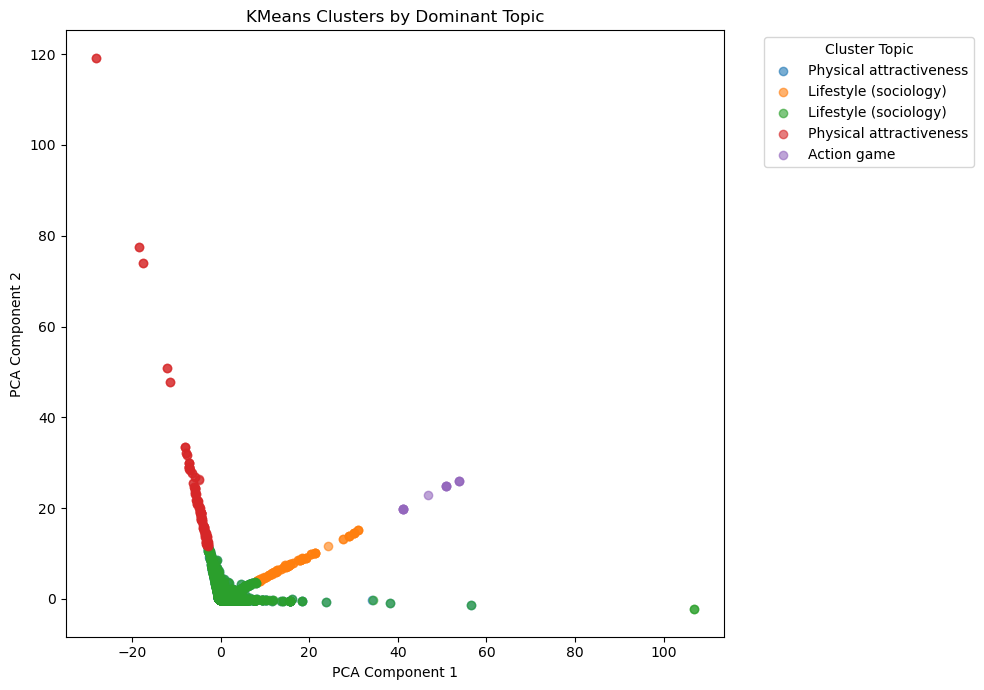

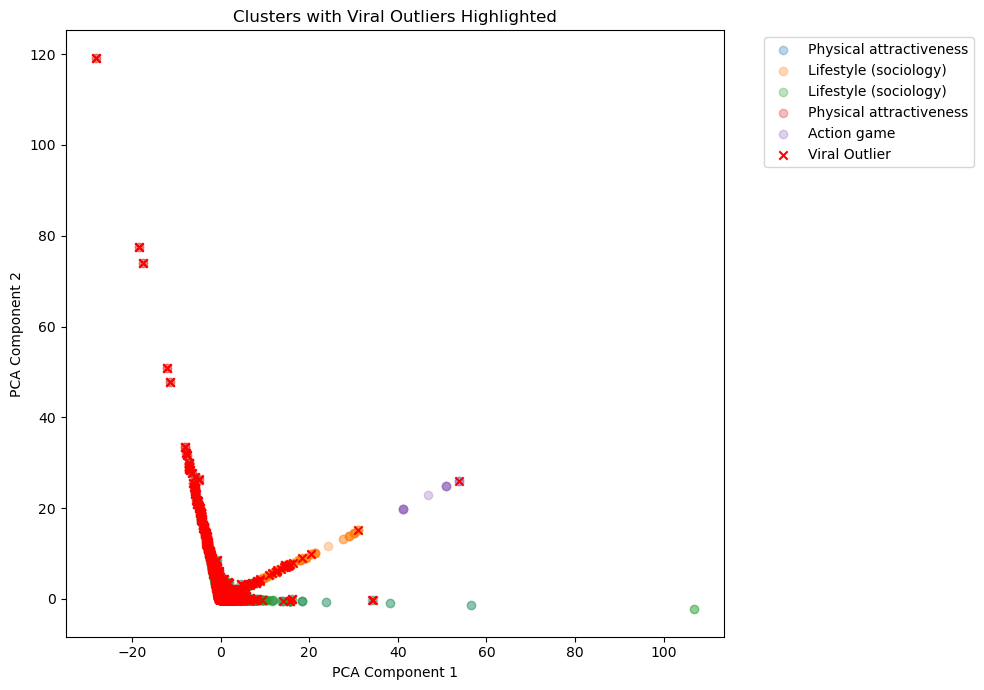

In [80]:
# Dimensionality reduction for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 7))
for i, label in enumerate(cluster_labels):
    idx = df_cluster['cluster'] == i
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=label, alpha=0.6)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('KMeans Clusters by Dominant Topic')
plt.legend(title="Cluster Topic", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Hightlight clusters with viral outliers
plt.figure(figsize=(10, 7))
for i, label in enumerate(cluster_labels):
    idx = df_cluster['cluster'] == i
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=label, alpha=0.3)

outliers = df_cluster['outlier_score'] == -1
plt.scatter(X_pca[outliers, 0], X_pca[outliers, 1],
            color='red', label='Viral Outlier', marker='x')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Clusters with Viral Outliers Highlighted')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
